# Wikipedia Movie Classification
### Dataset contains descriptions for 34,886 movies from around the world. Columns are:
 Release Year, Title, Origin, Director, Plot, Genre , Wiki Page, Plot

# 1. Libraries

In [230]:
#Imported Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import pickle 
import time

from nltk.tokenize import TweetTokenizer
import nltk
from nltk import Text
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

# 2. Cleansing

In [228]:
movies = pd.read_csv('/..input/wiki_movie_plots_deduped.csv', delimiter=',')
numRow, numCol = movies.shape
print("Number of the movies: {}\nNumber of the columns: {}".format(numRow,numCol))

Number of the movies: 34886
Number of the columns: 8


In [161]:
movies.dtypes

Release Year         int64
Title               object
Origin/Ethnicity    object
Director            object
Cast                object
Genre               object
Wiki Page           object
Plot                object
dtype: object

In [162]:
movies.head(10)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab..."
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
8,1905,The Little Train Robbery,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Little_Train...,The opening scene shows the interior of the ro...
9,1905,The Night Before Christmas,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Night_Before...,Scenes are introduced using lines of the poem....


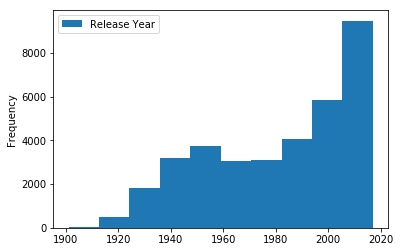

In [163]:
#Number of movies by date
hist = movies.plot.hist()

In [164]:
#Number of the Genres
movies['Count']=1
movies[['Genre','Count']].groupby(['Genre'], as_index=0).count().shape[0]

2265

In [165]:
%load /..input/GenreCorrected.py

#### Sorting the Genres after cleansing


In [166]:
moviesGenre = movies[['GenreCorrected','Count']].groupby(['GenreCorrected']).count()
moviesGenre.to_csv('GenreCorrected.csv',sep=',')
movies['GenreCorrected'] =movies['Genre'] 
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('unknown','')
movies[['GenreCorrected','Count']].groupby(['GenreCorrected'],as_index=False).count().sort_values(['Count'], ascending=False).head(50)

,GenreCorrected,Count
0,,6083
864,drama,5964
574,comedy,4379
1391,horror,1167
8,action,1098
2115,thriller,966
1727,romance,923
2210,western,865
754,crime,568
289,adventure,526


In [167]:
movies['GenreSplit']=movies['GenreCorrected'].str.split('>')
movies['GenreSplit']= movies['GenreSplit'].apply(np.sort).apply(np.unique)
movies['GenreSplit'][11]

array(['short action/crime western'], dtype='<U26')

In [168]:
genres_numpy = np.array([])
for i in range(0,movies.shape[0]-1):
    genres_numpy = np.concatenate((genres_numpy, movies['GenreSplit'][i] ))
genres_numpy

array(['', '', '', ..., 'comedy', 'comedy', 'romantic comedy'],
      dtype='<U81')

In [169]:
genres = pd.DataFrame({'Genre':genres_numpy})
genres.head(10)

,Genre
0,
1,
2,
3,
4,
5,
6,western
7,comedy
8,
9,


In [170]:
genres['Count']=1
genres[['Genre','Count']].groupby(['Genre'], as_index=False).sum().sort_values(['Count'], ascending=False).head(10)

,Genre,Count
0,,6083
864,drama,5964
574,comedy,4379
1391,horror,1167
8,action,1098
2115,thriller,966
1727,romance,923
2210,western,865
754,crime,568
289,adventure,526


### Describing selected genres

In [171]:
genres=genres[['Genre','Count']].groupby(['Genre'], as_index=False).sum().sort_values(['Count'], ascending=False)
genres = genres[genres['Genre']!='']
genres.head(25)

,Genre,Count
864,drama,5964
574,comedy,4379
1391,horror,1167
8,action,1098
2115,thriller,966
1727,romance,923
2210,western,865
754,crime,568
289,adventure,526
1554,musical,467


In [172]:
SumOfGenres=sum(genres['Count'])
SumOfGenres

28802

In [173]:
genres['Rate'] = genres['Count']/SumOfGenres
genres['CRate'] = genres['Rate'].cumsum()
genres.head(20)

,Genre,Count,Rate,CRate
864,drama,5964,0.207069,0.207069
574,comedy,4379,0.152038,0.359107
1391,horror,1167,0.040518,0.399625
8,action,1098,0.038122,0.437747
2115,thriller,966,0.033539,0.471287
1727,romance,923,0.032046,0.503333
2210,western,865,0.030033,0.533366
754,crime,568,0.019721,0.553087
289,adventure,526,0.018263,0.571349
1554,musical,467,0.016214,0.587563


In [174]:
np.array(genres[genres['CRate']<=.957]['Genre'])

array(['drama', 'comedy', 'horror', ..., 'adventure, mystery, thriller',
       'pawan kalyan, reema sen, meera chopra, mukesh rishi',
       'pawan kalyan, asin, sandhya'], dtype=object)

In [175]:
mainGenres=np.array(genres[genres['CRate']<=.957]['Genre'])

In [176]:
arr1=np.array(['adult', 'romance', 'drama','and'])
arr1[np.in1d(arr1,mainGenres)]

array(['adult', 'romance', 'drama'], dtype='<U7')

In [177]:
movies['GenreSplit'][10:12].apply(lambda x: x[np.in1d(x,mainGenres)])

10    [short]
11         []
Name: GenreSplit, dtype: object

In [178]:
movies['GenreSplitMain'] = movies['GenreSplit'].apply(lambda x: x[np.in1d(x,mainGenres)])
movies[['GenreSplitMain','GenreSplit','Genre']][420:440]

,GenreSplitMain,GenreSplit,Genre
420,[drama],[drama],drama
421,[drama],[drama],drama
422,[horror],[horror],horror
423,[drama],[drama],drama
424,[comedy drama],[comedy drama],comedy drama
425,[comedy],[comedy],comedy
426,[comedy],[comedy],comedy
427,[drama],[drama],drama
428,[comedy],[comedy],comedy
429,[drama],[drama],drama


In [179]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = text.strip(' ')
    return text

In [180]:
list(movies['Plot'][7:10].apply(clean_text))
list(movies['Plot'][7:10])

['The film is about a family who move to the suburbs, hoping for a quiet life. Things start to go wrong, and the wife gets violent and starts throwing crockery, leading to her arrest.',
 'The opening scene shows the interior of the robbers\' den. The walls are decorated with the portraits of notorious criminals and pictures illustrating the exploits of famous bandits. Some of the gang are lounging about, while others are reading novels and illustrated papers. Although of youthful appearance, each is dressed like a typical Western desperado. The "Bandit Queen," leading a blindfolded new recruit, now enters the room. He is led to the center of the room, raises his right hand and is solemnly sworn in. When the bandage is removed from his eyes he finds himself looking into the muzzles of a dozen or more 45\'s. The gang then congratulates the new member and heartily shake his hand. The "Bandit Queen" who is evidently the leader of the gang, now calls for volunteers to hold up a train. All r

In [181]:
movies['PlotClean'] = movies['Plot'].apply(clean_text)
movies[['Plot','PlotClean','GenreSplitMain']][10:15]

,Plot,PlotClean,GenreSplitMain
10,The Rarebit Fiend gorges on Welsh rarebit at a...,the rarebit fiend gorges on welsh rarebit at a...,[short]
11,The film features a train traveling through th...,the film features a train traveling through th...,[]
12,Irish villager Kathleen is a tenant of Captain...,irish villager kathleen is a tenant of captain...,[short film]
13,Boone's daughter befriends an Indian maiden as...,boone daughter befriends an indian maiden as ...,[biographical]
14,Before heading out to a baseball game at a nea...,before heading out to a baseball game at a nea...,[comedy]


In [182]:
len(movies['GenreSplitMain'][0])

0

In [183]:
movies['GenreSplitMain'][0:5].apply(len)

0    0
1    0
2    0
3    0
4    0
Name: GenreSplitMain, dtype: int64

In [184]:
movies['MainGenresCount'] = movies['GenreSplitMain'].apply(len)
max(movies['MainGenresCount'])

1

In [185]:
movies[movies['MainGenresCount']==1]

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Count,GenreCorrected,GenreSplit,GenreSplitMain,PlotClean,MainGenresCount
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...,1,western,[western],[western],the film opens with two bandits breaking into ...,1
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,1,comedy,[comedy],[comedy],the film is about a family who move to the sub...,1
10,1906,Dream of a Rarebit Fiend,American,Wallace McCutcheon and Edwin S. Porter,NaN,short,https://en.wikipedia.org/wiki/Dream_of_a_Rareb...,The Rarebit Fiend gorges on Welsh rarebit at a...,1,short,[short],[short],the rarebit fiend gorges on welsh rarebit at a...,1
12,1906,Kathleen Mavourneen,American,Edwin S. Porter,NaN,short film,https://en.wikipedia.org/wiki/Kathleen_Mavourn...,Irish villager Kathleen is a tenant of Captain...,1,short film,[short film],[short film],irish villager kathleen is a tenant of captain...,1
13,1907,Daniel Boone,American,Wallace McCutcheon and Ediwin S. Porter,"William Craven, Florence Lawrence",biographical,https://en.wikipedia.org/wiki/Daniel_Boone_(19...,Boone's daughter befriends an Indian maiden as...,1,biographical,[biographical],[biographical],boone daughter befriends an indian maiden as ...,1
14,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...,1,comedy,[comedy],[comedy],before heading out to a baseball game at a nea...,1
15,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...,1,comedy,[comedy],[comedy],the plot is that of a black woman going to the...,1
16,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...,1,drama,[drama],[drama],on a beautiful summer day a father and mother ...,1
17,1908,The Black Viper,American,D. W. Griffith,D. W. Griffith,drama,https://en.wikipedia.org/wiki/The_Black_Viper,A thug accosts a girl as she leaves her workpl...,1,drama,[drama],[drama],a thug accosts a girl as she leaves her workpl...,1
18,1908,A Calamitous Elopement,American,D.W. Griffith,"Harry Solter, Linda Arvidson",comedy,https://en.wikipedia.org/wiki/A_Calamitous_Elo...,A young couple decides to elope after being ca...,1,comedy,[comedy],[comedy],a young couple decides to elope after being ca...,1


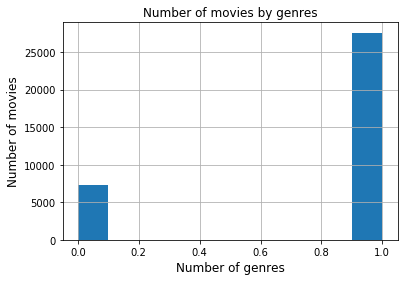

In [186]:
movies['MainGenresCount'].hist()
plt.title("Number of movies by genres")
plt.ylabel('Number of movies', fontsize=12)
plt.xlabel('Number of genres', fontsize=12)
plt.show()

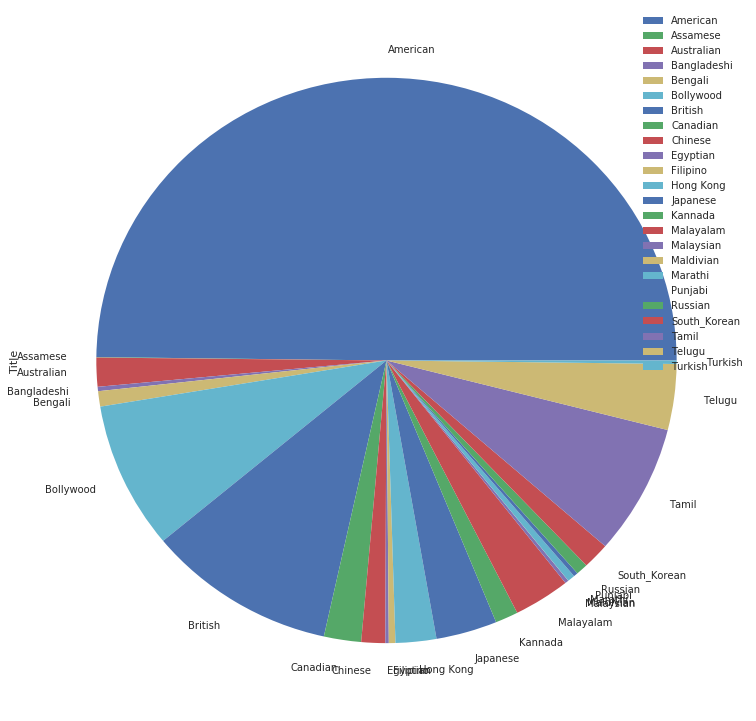

In [229]:
#Number of movies by country
columns = ['Release Year', 'Director','Cast', 'Genre', 'Wiki Page', 'Plot']
dfPie = movies.drop(columns, axis=1)

dfPie = dfPie.groupby(['Origin/Ethnicity']).count()
pie = dfPie.plot.pie(subplots=1, figsize=(13, 13))

### Classfying Training

In [189]:
txt = ["He is ::having a great Time, at the park time?",
       "She, unlike most women, is a big player on the park's grass.",
       "she can't be going"]
txt

['He is ::having a great Time, at the park time?',
 "She, unlike most women, is a big player on the park's grass.",
 "she can't be going"]

In [190]:
count_vec = CountVectorizer(stop_words="english", analyzer='word',ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)

In [191]:
count_train = count_vec.fit(txt)
bag_of_words = count_vec.transform(txt)
print("Every feature:\n{}".format(count_vec.get_feature_names()))
print("\nEvery 3rd feature:\n{}".format(count_vec.get_feature_names()[::3]))

Every feature:
['big', 'going', 'grass', 'great', 'having', 'park', 'player', 'time', 'unlike', 'women']

Every 3rd feature:
['big', 'great', 'player', 'women']


In [192]:
count_vec.get_feature_names()[:3]

['big', 'going', 'grass']

In [193]:
movies = pd.concat([movies, movies.GenreSplitMain.apply(lambda x: '-'.join(x)).str.get_dummies(sep='-')], axis=1)

In [131]:
tfidf = TfidfVectorizer(stop_words ='english', smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')

In [194]:
# This will be build when there is at least one genre for a movie
MoviesTrain, MoviesTest = train_test_split(movies[movies.GenreCorrected!=''], random_state=42, test_size=0.30, shuffle=True)

In [195]:
MoviesTrain, MoviesTest = train_test_split(movies[movies.GenreCorrected!=''], random_state=42, test_size=0.30, shuffle=True)

In [196]:
x_train = tfidf.fit_transform(MoviesTrain.PlotClean) 
x_test  = tfidf.transform(MoviesTest.PlotClean)

In [198]:
print('Row of the MoviesTrain ={}'. format(MoviesTrain.shape[0]))
print('Row of the MoviesTest ={}'. format(MoviesTest.shape[0]))

Row of the MoviesTrain =20162
Row of the MoviesTest =8641


In [199]:
type(x_train)

scipy.sparse.csr.csr_matrix

In [200]:
tfidf.inverse_transform(x_train[0].toarray())

[array(['american', 'apart', 'argue', 'attempting', 'attempts', 'better',
        'boss', 'boy', 'child', 'coming', 'continuing', 'contract',
        'country', 'daughter', 'deported', 'desiring', 'desperate',
        'dream', 'enraged', 'enters', 'eventually', 'falls', 'fathered',
        'fujian', 'habits', 'hears', 'home', 'hong', 'informs', 'ins',
        'jobless', 'kidnaps', 'known', 'life', 'like', 'listless',
        'measures', 'old', 'opera', 'paper', 'performer', 'quickly',
        'romance', 'ruifang', 'sign', 'son', 'states', 'takes', 'time',
        'told', 'town', 'traveling', 'undocumented', 'unemployed',
        'united', 'violates', 'visit', 'wanderer', 'wandering', 'worker',
        'wu', 'yunsheng'], dtype='<U34')]

In [208]:
# building the classes
y_train = MoviesTrain[MoviesTrain.columns[14:]]
y_test = MoviesTest[MoviesTest.columns[14:]]

### Multinomial Naive Bayes Classification

In [204]:
multinomialNB=OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))

In [205]:
multinomialNB.fit(x_train, y_train.action)

OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=None)

In [206]:
# compute the testing accuracy
prediction = multinomialNB.predict(x_test)

In [207]:
print('Test accuracy is {}'.format(accuracy_score(y_test.action, prediction)))

Test accuracy is 0.9192223122323805


### Naive Bayes Classification genres

In [213]:
accuracy_multinomialNB=pd.DataFrame(columns=['Genre', 'accuracy_multinomialNB'])
accuracy_multinomialNB.head()

,Genre,accuracy_multinomialNB


In [217]:
i = 0
for genre in mainGenres:
    if i == 26:
        continue
        multinomialNB.fit(x_train, y_train[genre])
        prediction = multinomialNB.predict(x_test)
        accuracy_multinomialNB.loc[i,'Genre'] = genre
        accuracy_multinomialNB.loc[i,'accuracy_multinomialNB'] = accuracy_score(y_test[genre], prediction)
    i=i+1
    

    
accuracy_multinomialNB

,Genre,accuracy_multinomialNB
0,drama,0.716121
1,comedy,0.778035
2,horror,0.955561
3,action,0.919222
4,thriller,0.938433
5,romance,0.896077
6,western,0.98403
7,crime,0.967365
8,adventure,0.966092
9,musical,0.968406


### Linear SVM for movie genres

In [218]:
linearSVC=OneVsRestClassifier(LinearSVC(), n_jobs=1)
accuracy_LinearSVC=pd.DataFrame(columns=['Genre', 'accuracy_LinearSVC'])
accuracy_LinearSVC.head()

,Genre,accuracy_LinearSVC


In [219]:
i = 0
for genre in mainGenres:
    linearSVC.fit(x_train, y_train[genre])
    prediction = linearSVC.predict(x_test)
    accuracy_LinearSVC.loc[i,'Genre'] = genre
    accuracy_LinearSVC.loc[i,'accuracy_LinearSVC'] = accuracy_score(y_test[genre], prediction)
    i=i+1

/home/han/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/han/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/han/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/han/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/han/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the

KeyError: 'sci-fi'

In [220]:
accuracy_LinearSVC

,Genre,accuracy_LinearSVC
0,drama,0.7248
1,comedy,0.803495
2,horror,0.959264
3,action,0.947923
4,thriller,0.947113
5,romance,0.953362
6,western,0.983567
7,crime,0.969101
8,adventure,0.978243
9,musical,0.978475


In [221]:
accuracy_svc_mnb = pd.merge(accuracy_multinomialNB, accuracy_LinearSVC, on='Genre', how='inner')
accuracy_svc_mnb

,Genre,accuracy_multinomialNB,accuracy_LinearSVC
0,drama,0.716121,0.7248
1,comedy,0.778035,0.803495
2,horror,0.955561,0.959264
3,action,0.919222,0.947923
4,thriller,0.938433,0.947113
5,romance,0.896077,0.953362
6,western,0.98403,0.983567
7,crime,0.967365,0.969101
8,adventure,0.966092,0.978243
9,musical,0.968406,0.978475
